In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from model import Model
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import scienceplots

In [2]:
plt.style.use(['science', 'no-latex'])

In [3]:
model_eigenvectors = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actrelu.pt")
model_simulation = torch.jit.load("../models/simulation_cosine_similarity_skip10_batch64_modelstandard_actrelu.pt")

In [4]:
input_vectors = []
output_vectors_eigenvectors = []
output_vectors_simulation = []
for i in range(1000):
    input_vector = np.loadtxt(f"../data/karman_data/res_{i}.dat")
    input_vector = torch.tensor(input_vector).float().unsqueeze(0).unsqueeze(0).to('cuda')
    output_vectors_eigenvectors.append(model_eigenvectors(input_vector).cpu().detach().numpy().flatten())
    output_vectors_simulation.append(model_simulation(input_vector).cpu().detach().numpy().flatten())
    input_vectors.append(input_vector.cpu().detach().numpy().flatten())

In [5]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

In [6]:
X = np.vstack(input_vectors)
Y_eig = np.vstack(output_vectors_eigenvectors)
Y_sim = np.vstack(output_vectors_simulation)
Y_inv = X.dot(A_inverse)

In [7]:
Y_eig_scaled = Y_eig.copy()
Y_sim_scaled = Y_sim.copy()
for i in range(Y_eig.shape[0]):
    Y_eig[i] = np.abs(Y_eig[i])
    Y_sim[i] = np.abs(Y_sim[i])
    Y_inv[i] = np.abs(Y_inv[i])
    Y_eig_scaled[i] = (Y_eig[i] - np.min(Y_eig[i])) / (np.max(Y_eig[i]) - np.min(Y_eig[i])) * (np.max(Y_inv[i]) - np.min(Y_inv[i])) + np.min(Y_inv[i])
    Y_sim_scaled[i] = (Y_sim[i] - np.min(Y_sim[i])) / (np.max(Y_sim[i]) - np.min(Y_sim[i])) * (np.max(Y_inv[i]) - np.min(Y_inv[i])) + np.min(Y_inv[i])

In [8]:
ssim_indexes_eig = []
ssim_eig_images = []
ssim_indexes_sim = []
ssim_sim_images = []
for i in range(Y_eig_scaled.shape[0]):
    ssim_index, ssim_image = ssim(Y_eig_scaled[i].reshape(34, 34), Y_inv[i].reshape(34, 34), full=True, data_range=Y_eig_scaled[i].reshape(34, 34).max() - Y_eig_scaled[i].reshape(34, 34).min())
    ssim_indexes_eig.append(ssim_index)
    ssim_eig_images.append(ssim_image)
    ssim_index, ssim_image = ssim(Y_sim_scaled[i].reshape(34, 34), Y_inv[i].reshape(34, 34), full=True, data_range=Y_sim_scaled[i].reshape(34, 34).max() - Y_sim_scaled[i].reshape(34, 34).min())
    ssim_indexes_sim.append(ssim_index)
    ssim_sim_images.append(ssim_image)


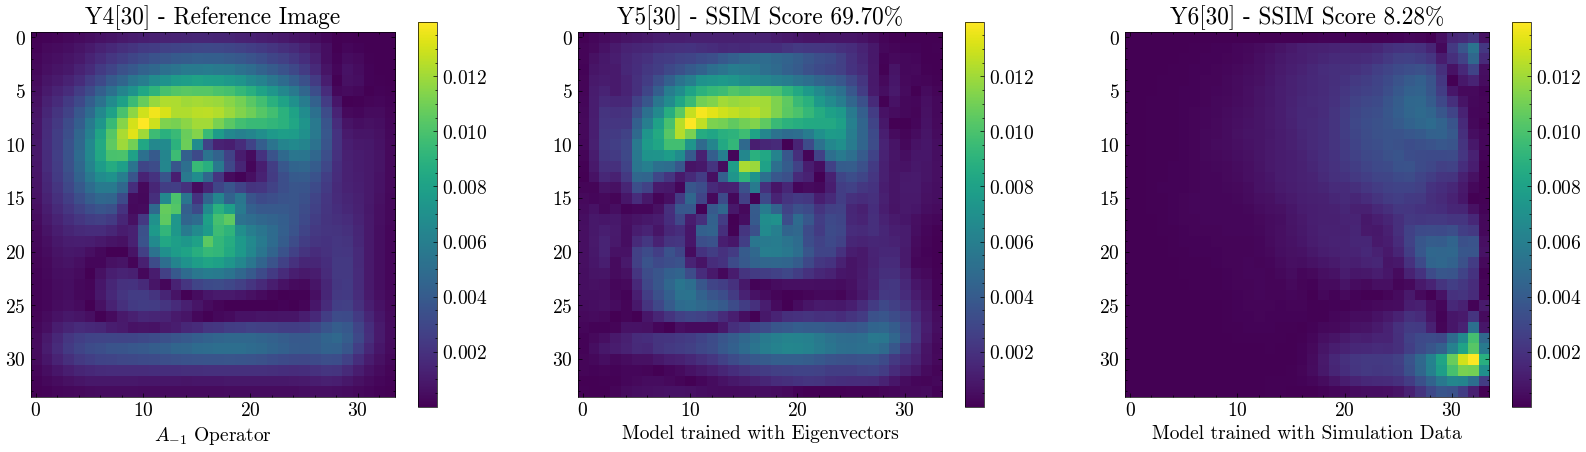

In [17]:
# plot imshow y_eig_scaled, y_inv and ssim_eig_images on subplots 1x3
index = 30
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=3)
ax[0].imshow(Y_inv[index].reshape(34, 34))
plt.colorbar(ax[0].imshow(Y_inv[index].reshape(34, 34)))
ax[0].set_title(f"Y4[{index}] - Reference Image")
ax[0].set_xlabel("$A_{-1}$ Operator")

ax[1].imshow(Y_eig[index].reshape(34, 34))
plt.colorbar(ax[1].imshow(Y_eig_scaled[index].reshape(34, 34)))
ax[1].set_title(f"Y5[{index}] - SSIM Score {ssim_indexes_eig[index]*100:.2f}%")
ax[1].set_xlabel("Model trained with Eigenvectors")

ax[2].imshow(Y_sim_scaled[index].reshape(34, 34))
plt.colorbar(ax[2].imshow(Y_sim_scaled[index].reshape(34, 34)))
ax[2].set_title(f"Y6[{index}] - SSIM Score {ssim_indexes_sim[index]*100:.2f}%")
ax[2].set_xlabel("Model trained with Simulation Data")
plt.savefig("ssim_karman_examples.pdf", bbox_inches='tight', format='pdf')


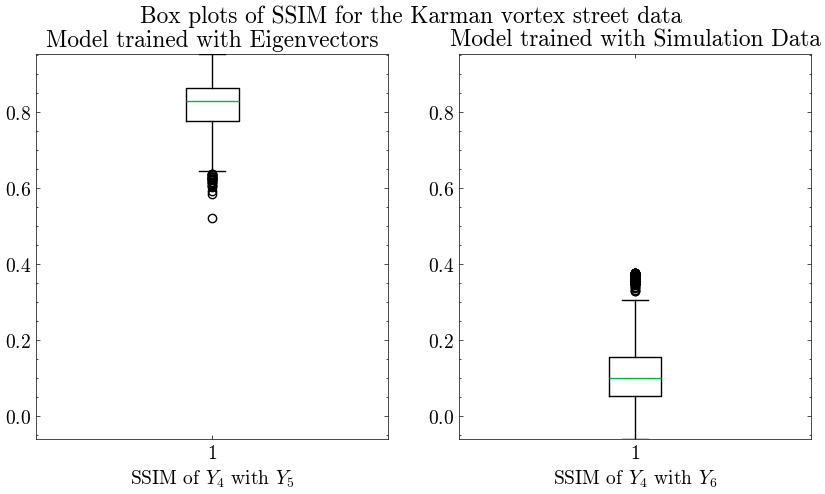

In [23]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.boxplot(ssim_indexes_eig)
plt.title("Model trained with Eigenvectors")
plt.xlabel("SSIM of $Y_{4}$ with $Y_{5}$")
plt.ylim(min(min(ssim_indexes_eig), min(ssim_indexes_sim)), max(max(ssim_indexes_eig), max(ssim_indexes_sim)))

plt.subplot(1, 2, 2)
plt.boxplot(ssim_indexes_sim)
plt.title("Model trained with Simulation Data")
plt.xlabel("SSIM of $Y_{4}$ with $Y_{6}$")
plt.ylim(min(min(ssim_indexes_eig), min(ssim_indexes_sim)), max(max(ssim_indexes_eig), max(ssim_indexes_sim)))

plt.suptitle("Box plots of SSIM for the Karman vortex street data")
plt.savefig("ssim_karman_boxplot.pdf", bbox_inches='tight', format='pdf')
plt.show()